# Titanic Kaggle Challenge: Advanced Feature Engineering
This notebook is based on the advanced feature engineering tutorial for the Titanic dataset available on Kaggle. The tutorial focuses on creating new features to improve model performance.
For more details, you can refer to the original tutorial here:
https://www.kaggle.com/code/gunesevitan/titanic-advanced-feature-engineering-tutorial?scriptVersionId=27280410

- Current score public score is 0.8 (best score in public leaderboard (legit score) is about 0.82 (top 2%)).
-  My score is 0.8.~ 446th place in public leaderboard the top (~ top 3%)



In [399]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold

import string
import warnings
warnings.filterwarnings('ignore')
import os 

SEED = 42

In [400]:
def concat_df(train_data, test_data):
    # Returns a concatenated df of training and test set
    return pd.concat([train_data, test_data], sort=True).reset_index(drop=True)

def divide_df(all_data):
    # Returns divided dfs of training and test set
    return all_data.loc[:890], all_data.loc[891:].drop(['Survived'], axis=1)

root_folder = os.path.dirname(os.getcwd())
df_train = pd.read_csv(os.path.join(root_folder, 'data', 'titanic', 'train.csv'))
df_test = pd.read_csv(os.path.join(root_folder, 'data', 'titanic', 'test.csv'))
df_all = concat_df(df_train, df_test)

df_train.name = 'Training Set'
df_test.name = 'Test Set'
df_all.name = 'All Set' 

dfs = [df_train, df_test]

print('Number of Training Examples = {}'.format(df_train.shape[0]))
print('Number of Test Examples = {}\n'.format(df_test.shape[0]))
print('Training X Shape = {}'.format(df_train.shape))
print('Training y Shape = {}\n'.format(df_train['Survived'].shape[0]))
print('Test X Shape = {}'.format(df_test.shape))
print('Test y Shape = {}\n'.format(df_test.shape[0]))
print(df_train.columns)
print(df_test.columns)

Number of Training Examples = 891
Number of Test Examples = 418

Training X Shape = (891, 12)
Training y Shape = 891

Test X Shape = (418, 11)
Test y Shape = 418

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')
Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')


In [401]:
def display_missing(df):    
    for col in df.columns.tolist():          
        print('{} column missing values: {}'.format(col, df[col].isnull().sum()))
    print('\n')
    
for df in dfs:
    print('{}'.format(df.Name))
    display_missing(df)

0                                Braund, Mr. Owen Harris
1      Cumings, Mrs. John Bradley (Florence Briggs Th...
2                                 Heikkinen, Miss. Laina
3           Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                               Allen, Mr. William Henry
                             ...                        
886                                Montvila, Rev. Juozas
887                         Graham, Miss. Margaret Edith
888             Johnston, Miss. Catherine Helen "Carrie"
889                                Behr, Mr. Karl Howell
890                                  Dooley, Mr. Patrick
Name: Name, Length: 891, dtype: object
PassengerId column missing values: 0
Survived column missing values: 0
Pclass column missing values: 0
Name column missing values: 0
Sex column missing values: 0
Age column missing values: 177
SibSp column missing values: 0
Parch column missing values: 0
Ticket column missing values: 0
Fare column missing values: 0
Cabin column miss

In [402]:
df_all

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450
...,...,...,...,...,...,...,...,...,...,...,...,...
1304,NaN,NaN,S,8.0500,"Spector, Mr. Woolf",0,1305,3,male,0,NaN,A.5. 3236
1305,39.0,C105,C,108.9000,"Oliva y Ocana, Dona. Fermina",0,1306,1,female,0,NaN,PC 17758
1306,38.5,NaN,S,7.2500,"Saether, Mr. Simon Sivertsen",0,1307,3,male,0,NaN,SOTON/O.Q. 3101262
1307,NaN,NaN,S,8.0500,"Ware, Mr. Frederick",0,1308,3,male,0,NaN,359309


In [403]:
df_all[df_all['Embarked'].isnull()]
# Filling the missing values in Embarked with S
df_all['Embarked'] = df_all['Embarked'].fillna('S')
df_all[df_all['Fare'].isnull()]

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
1043,60.5,NaN,S,NaN,"Storey, Mr. Thomas",0,1044,3,male,0,NaN,3701


In [404]:
med_fare = df_all.groupby(['Pclass', 'Parch', 'SibSp']).Fare.median()[3][0][0]
# Filling the missing value in Fare with the median Fare of 3rd class alone passenger
df_all['Fare'] = df_all['Fare'].fillna(med_fare)

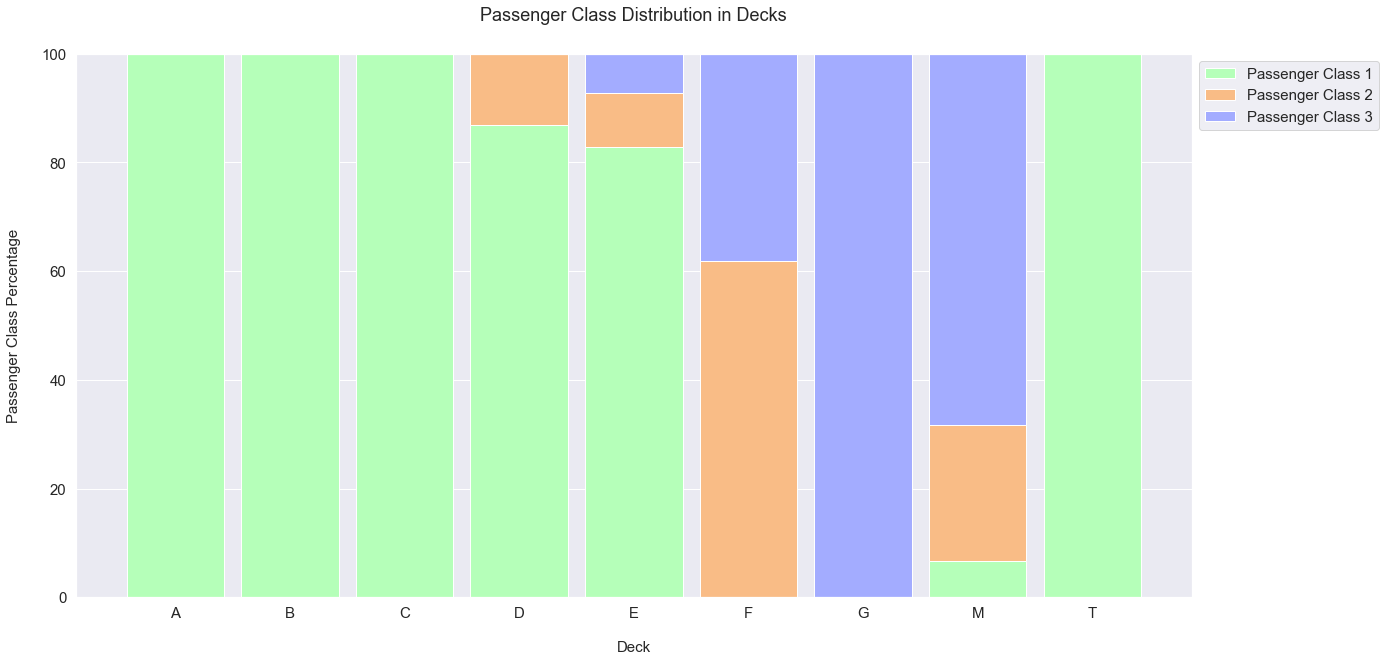

In [405]:
# Creating Deck column from the first letter of the Cabin column (M stands for Missing)
df_all['Deck'] = df_all['Cabin'].apply(lambda s: s[0] if pd.notnull(s) else 'M')

df_all_decks = df_all.groupby(['Deck', 'Pclass']).count().drop(columns=['Survived', 'Sex', 'Age', 'SibSp', 'Parch', 
                                                                        'Fare', 'Embarked', 'Cabin', 'PassengerId', 'Ticket']).rename(columns={'Name': 'Count'}).transpose()

def get_pclass_dist(df):
    
    # Creating a dictionary for every passenger class count in every deck
    deck_counts = {'A': {}, 'B': {}, 'C': {}, 'D': {}, 'E': {}, 'F': {}, 'G': {}, 'M': {}, 'T': {}}
    decks = df.columns.levels[0]    
    
    for deck in decks:
        for pclass in range(1, 4):
            try:
                count = df[deck][pclass][0]
                deck_counts[deck][pclass] = count 
            except KeyError:
                deck_counts[deck][pclass] = 0
                
    df_decks = pd.DataFrame(deck_counts)    
    deck_percentages = {}

    # Creating a dictionary for every passenger class percentage in every deck
    for col in df_decks.columns:
        deck_percentages[col] = [(count / df_decks[col].sum()) * 100 for count in df_decks[col]]
        
    return deck_counts, deck_percentages

def display_pclass_dist(percentages):
    
    df_percentages = pd.DataFrame(percentages).transpose()
    deck_names = ('A', 'B', 'C', 'D', 'E', 'F', 'G', 'M', 'T')
    bar_count = np.arange(len(deck_names))  
    bar_width = 0.85
    
    pclass1 = df_percentages[0]
    pclass2 = df_percentages[1]
    pclass3 = df_percentages[2]
    
    plt.figure(figsize=(20, 10))
    plt.bar(bar_count, pclass1, color='#b5ffb9', edgecolor='white', width=bar_width, label='Passenger Class 1')
    plt.bar(bar_count, pclass2, bottom=pclass1, color='#f9bc86', edgecolor='white', width=bar_width, label='Passenger Class 2')
    plt.bar(bar_count, pclass3, bottom=pclass1 + pclass2, color='#a3acff', edgecolor='white', width=bar_width, label='Passenger Class 3')

    plt.xlabel('Deck', size=15, labelpad=20)
    plt.ylabel('Passenger Class Percentage', size=15, labelpad=20)
    plt.xticks(bar_count, deck_names)    
    plt.tick_params(axis='x', labelsize=15)
    plt.tick_params(axis='y', labelsize=15)
    
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), prop={'size': 15})
    plt.title('Passenger Class Distribution in Decks', size=18, y=1.05)   
    
    plt.show()    

all_deck_count, all_deck_per = get_pclass_dist(df_all_decks)
display_pclass_dist(all_deck_per)

In [406]:
# Passenger in the T deck is changed to A
idx = df_all[df_all['Deck'] == 'T'].index
df_all.loc[idx, 'Deck'] = 'A'

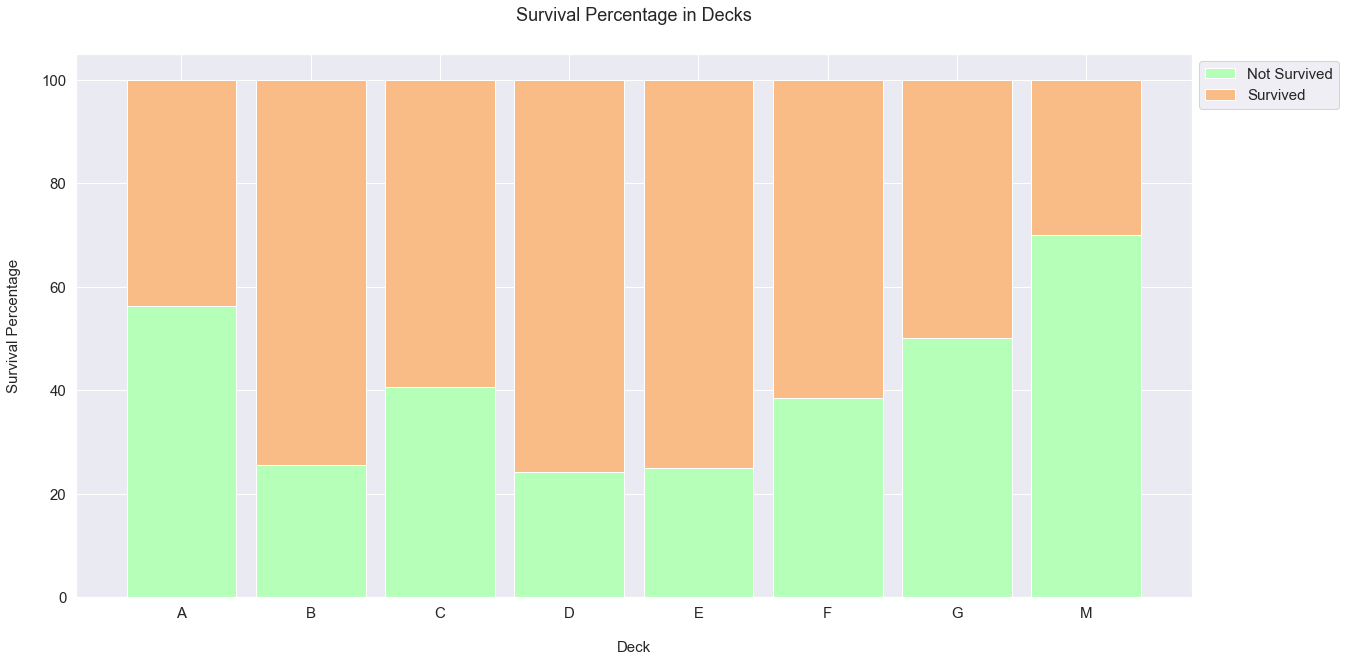

In [407]:
df_all_decks_survived = df_all.groupby(['Deck', 'Survived']).count().drop(columns=['Sex', 'Age', 'SibSp', 'Parch', 'Fare', 
                                                                                   'Embarked', 'Pclass', 'Cabin', 'PassengerId', 'Ticket']).rename(columns={'Name':'Count'}).transpose()

def get_survived_dist(df):
    
    # Creating a dictionary for every survival count in every deck
    surv_counts = {'A':{}, 'B':{}, 'C':{}, 'D':{}, 'E':{}, 'F':{}, 'G':{}, 'M':{}}
    decks = df.columns.levels[0]    

    for deck in decks:
        for survive in range(0, 2):
            surv_counts[deck][survive] = df[deck][survive][0]
            
    df_surv = pd.DataFrame(surv_counts)
    surv_percentages = {}

    for col in df_surv.columns:
        surv_percentages[col] = [(count / df_surv[col].sum()) * 100 for count in df_surv[col]]
        
    return surv_counts, surv_percentages

def display_surv_dist(percentages):
    
    df_survived_percentages = pd.DataFrame(percentages).transpose()
    deck_names = ('A', 'B', 'C', 'D', 'E', 'F', 'G', 'M')
    bar_count = np.arange(len(deck_names))  
    bar_width = 0.85    

    not_survived = df_survived_percentages[0]
    survived = df_survived_percentages[1]
    
    plt.figure(figsize=(20, 10))
    plt.bar(bar_count, not_survived, color='#b5ffb9', edgecolor='white', width=bar_width, label="Not Survived")
    plt.bar(bar_count, survived, bottom=not_survived, color='#f9bc86', edgecolor='white', width=bar_width, label="Survived")
 
    plt.xlabel('Deck', size=15, labelpad=20)
    plt.ylabel('Survival Percentage', size=15, labelpad=20)
    plt.xticks(bar_count, deck_names)    
    plt.tick_params(axis='x', labelsize=15)
    plt.tick_params(axis='y', labelsize=15)
    
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), prop={'size': 15})
    plt.title('Survival Percentage in Decks', size=18, y=1.05)
    
    plt.show()

all_surv_count, all_surv_per = get_survived_dist(df_all_decks_survived)
display_surv_dist(all_surv_per)

In [408]:
df_all['Deck'] = df_all['Deck'].replace(['A', 'B', 'C'], 'ABC')
df_all['Deck'] = df_all['Deck'].replace(['D', 'E'], 'DE')
df_all['Deck'] = df_all['Deck'].replace(['F', 'G'], 'FG')

df_all['Deck'].value_counts()

Deck
M      1014
ABC     182
DE       87
FG       26
Name: count, dtype: int64

In [409]:
# Dropping the Cabin feature
df_all.drop(['Cabin'], inplace=True, axis=1)

df_train, df_test = divide_df(df_all)
dfs = [df_train, df_test]

for df in dfs:
    display_missing(df)

Age column missing values: 177
Embarked column missing values: 0
Fare column missing values: 0
Name column missing values: 0
Parch column missing values: 0
PassengerId column missing values: 0
Pclass column missing values: 0
Sex column missing values: 0
SibSp column missing values: 0
Survived column missing values: 0
Ticket column missing values: 0
Deck column missing values: 0


Age column missing values: 86
Embarked column missing values: 0
Fare column missing values: 0
Name column missing values: 0
Parch column missing values: 0
PassengerId column missing values: 0
Pclass column missing values: 0
Sex column missing values: 0
SibSp column missing values: 0
Ticket column missing values: 0
Deck column missing values: 0




342 of 891 passengers survived and it is the 38.38% of the training set.
549 of 891 passengers didnt survive and it is the 61.62% of the training set.


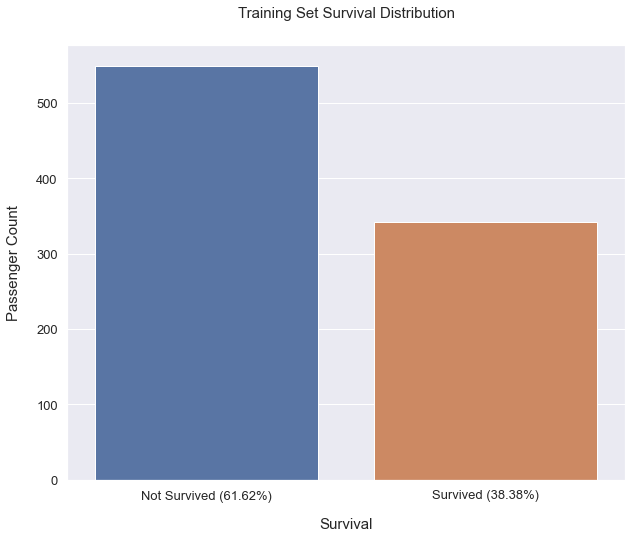

In [410]:
survived = df_train['Survived'].value_counts()[1]
not_survived = df_train['Survived'].value_counts()[0]
survived_per = survived / df_train.shape[0] * 100
not_survived_per = not_survived / df_train.shape[0] * 100

print('{} of {} passengers survived and it is the {:.2f}% of the training set.'.format(survived, df_train.shape[0], survived_per))
print('{} of {} passengers didnt survive and it is the {:.2f}% of the training set.'.format(not_survived, df_train.shape[0], not_survived_per))

plt.figure(figsize=(10, 8))
sns.countplot(df_train['Survived'])

plt.xlabel('Survival', size=15, labelpad=15)
plt.ylabel('Passenger Count', size=15, labelpad=15)
plt.xticks((0, 1), ['Not Survived ({0:.2f}%)'.format(not_survived_per), 'Survived ({0:.2f}%)'.format(survived_per)])
plt.tick_params(axis='x', labelsize=13)
plt.tick_params(axis='y', labelsize=13)

plt.title('Training Set Survival Distribution', size=15, y=1.05)

plt.show()

In [411]:
df_all = concat_df(df_train, df_test)
df_all.head()

,Age,Deck,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
0,22.0,M,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171
1,38.0,ABC,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599
2,26.0,M,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282
3,35.0,ABC,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803
4,35.0,M,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450


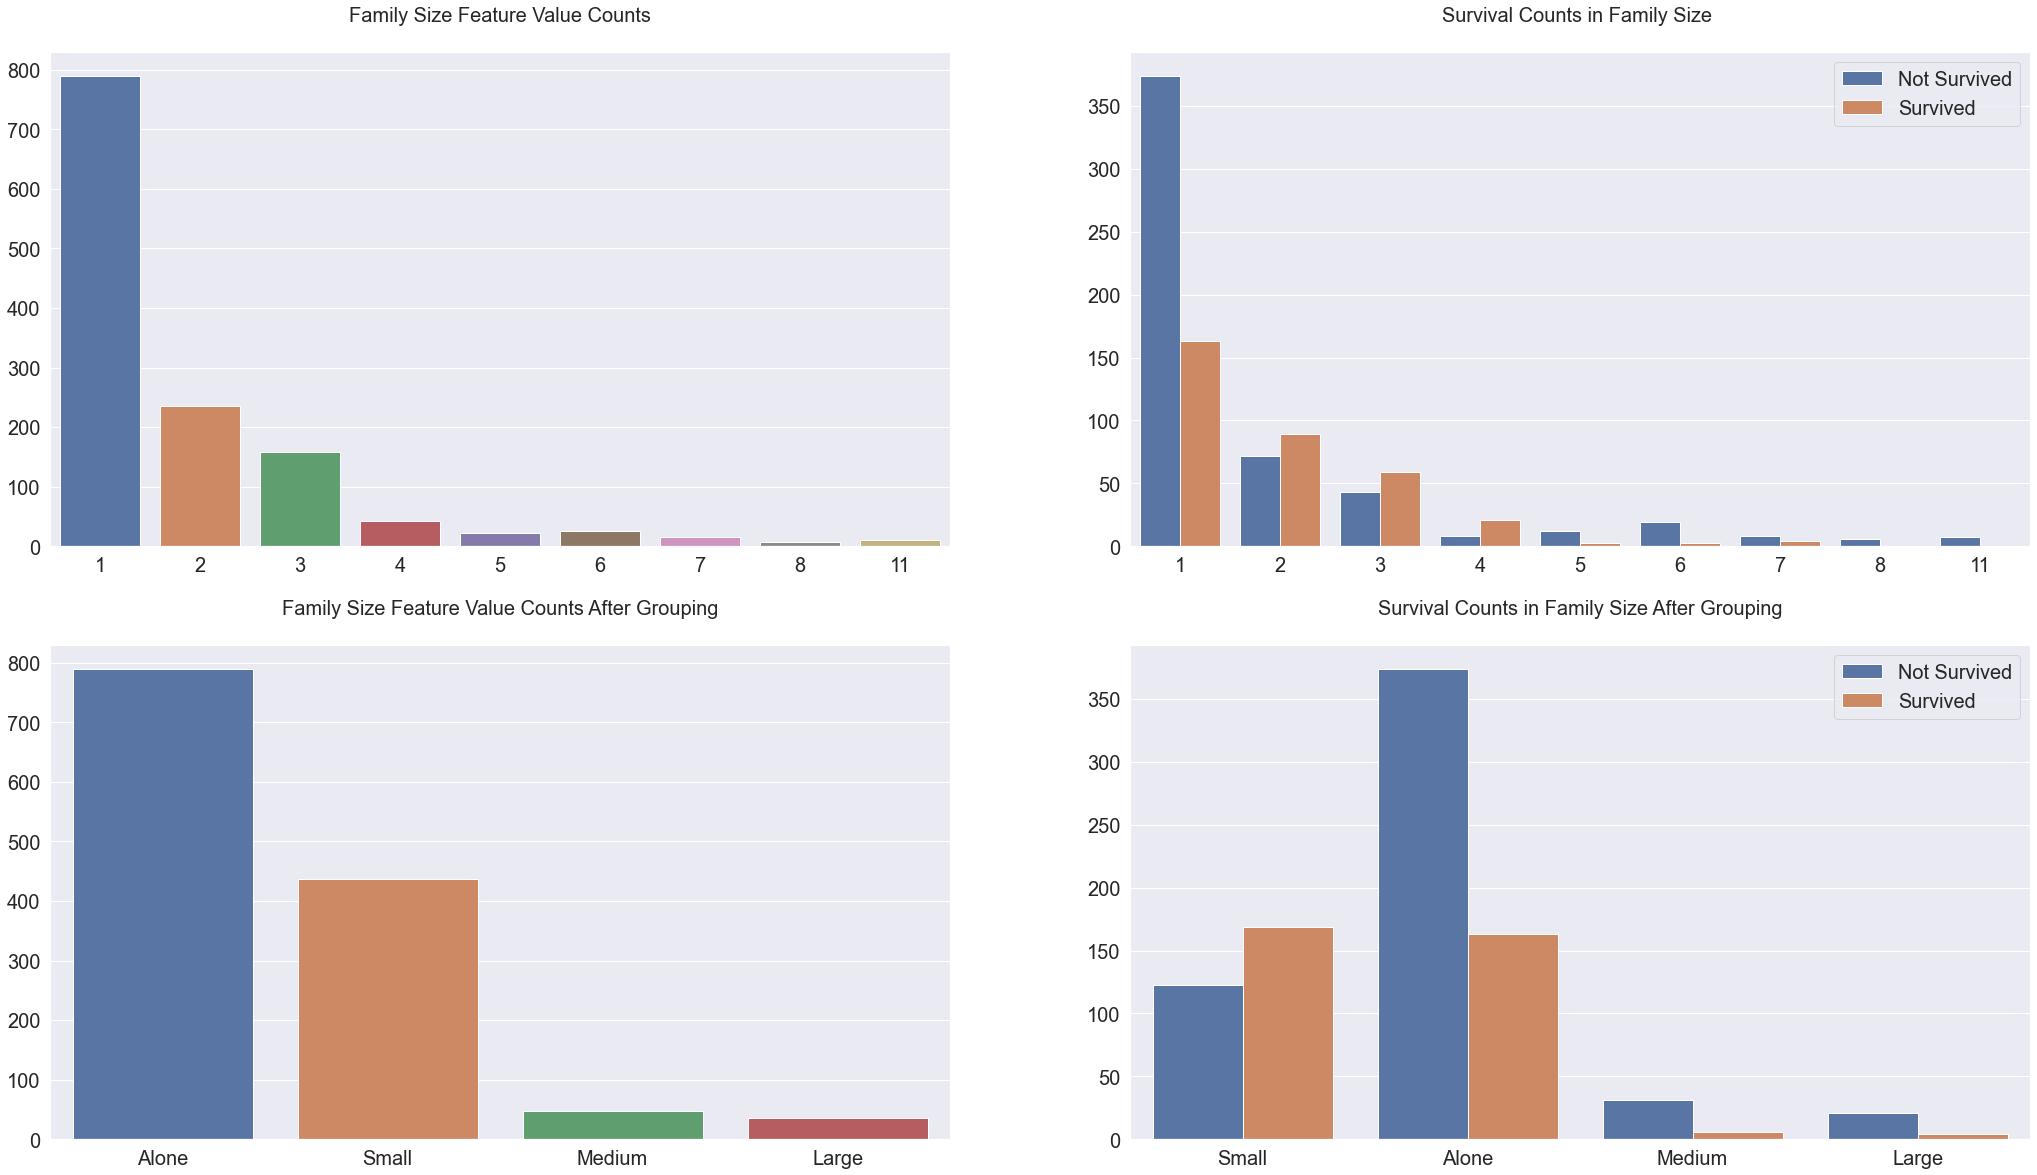

In [412]:
df_all['Fare'] = pd.qcut(df_all['Fare'], 13)
df_all['Age'] = pd.qcut(df_all['Age'], 10)
df_all['Family_Size'] = df_all['SibSp'] + df_all['Parch'] + 1

fig, axs = plt.subplots(figsize=(20, 20), ncols=2, nrows=2)
plt.subplots_adjust(right=1.5)

sns.barplot(x=df_all['Family_Size'].value_counts().index, y=df_all['Family_Size'].value_counts().values, ax=axs[0][0])
sns.countplot(x='Family_Size', hue='Survived', data=df_all, ax=axs[0][1])

axs[0][0].set_title('Family Size Feature Value Counts', size=20, y=1.05)
axs[0][1].set_title('Survival Counts in Family Size ', size=20, y=1.05)

family_map = {1: 'Alone', 2: 'Small', 3: 'Small', 4: 'Small', 5: 'Medium', 6: 'Medium', 7: 'Large', 8: 'Large', 11: 'Large'}
df_all['Family_Size_Grouped'] = df_all['Family_Size'].map(family_map)

sns.barplot(x=df_all['Family_Size_Grouped'].value_counts().index, y=df_all['Family_Size_Grouped'].value_counts().values, ax=axs[1][0])
sns.countplot(x='Family_Size_Grouped', hue='Survived', data=df_all, ax=axs[1][1])

axs[1][0].set_title('Family Size Feature Value Counts After Grouping', size=20, y=1.05)
axs[1][1].set_title('Survival Counts in Family Size After Grouping', size=20, y=1.05)

for i in range(2):
    axs[i][1].legend(['Not Survived', 'Survived'], loc='upper right', prop={'size': 20})
    for j in range(2):
        axs[i][j].tick_params(axis='x', labelsize=20)
        axs[i][j].tick_params(axis='y', labelsize=20)
        axs[i][j].set_xlabel('')
        axs[i][j].set_ylabel('')

plt.show()

In [413]:
df_all['Ticket_Frequency'] = df_all.groupby('Ticket')['Ticket'].transform('count')

In [414]:
df_all['Title'] = df_all['Name'].str.split(', ', expand=True)[1].str.split('.', expand=True)[0]
df_all['Is_Married'] = 0
df_all['Is_Married'].loc[df_all['Title'] == 'Mrs'] = 1

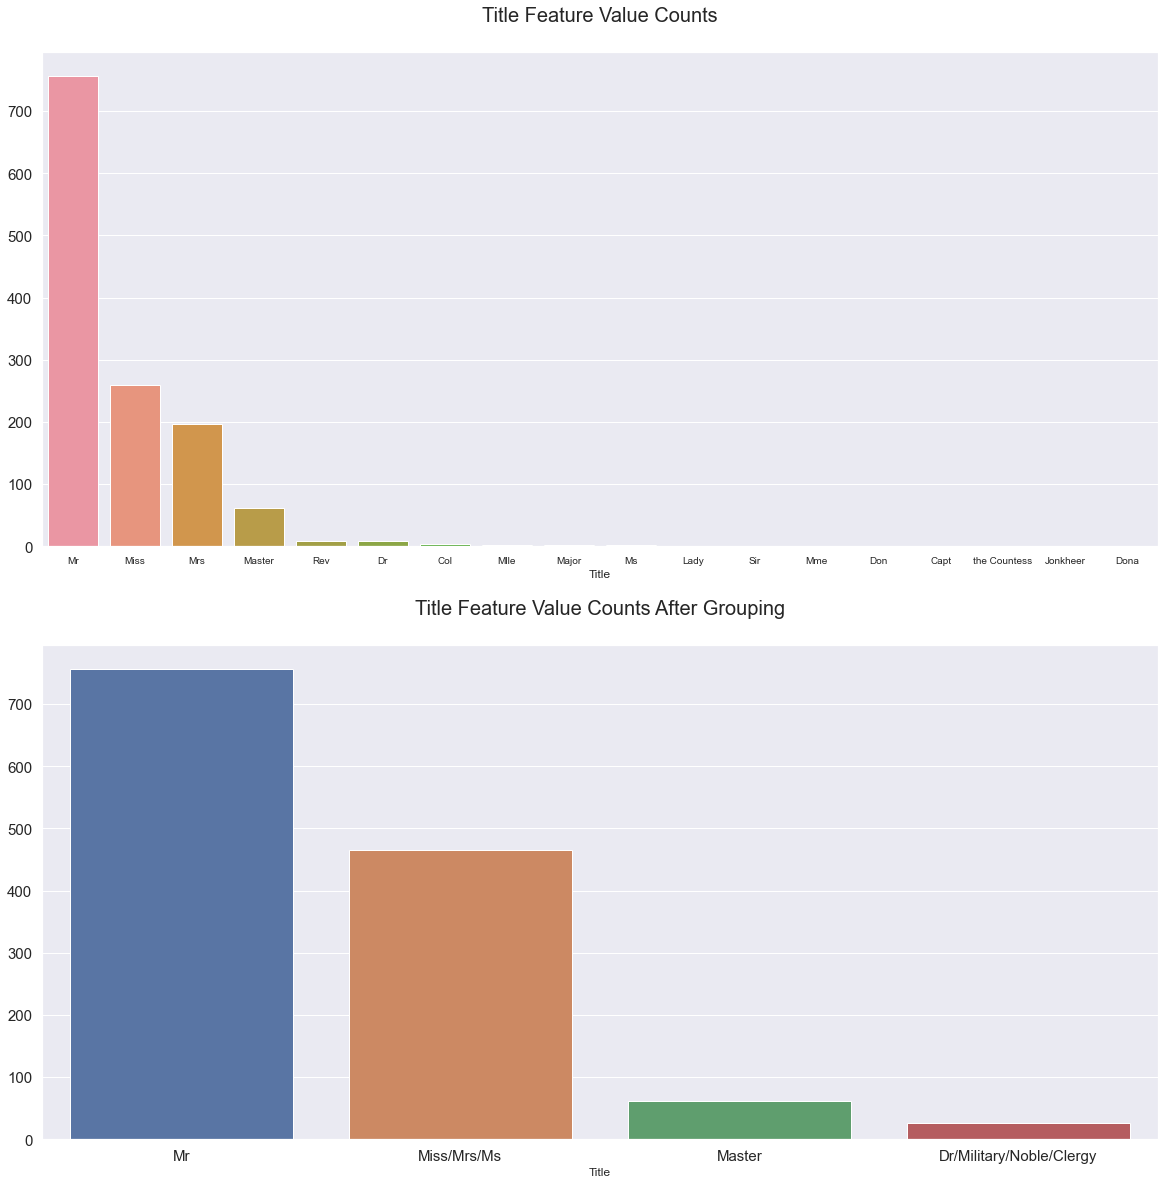

In [415]:
fig, axs = plt.subplots(nrows=2, figsize=(20, 20))
sns.barplot(x=df_all['Title'].value_counts().index, y=df_all['Title'].value_counts().values, ax=axs[0])

axs[0].tick_params(axis='x', labelsize=10)
axs[1].tick_params(axis='x', labelsize=15)

for i in range(2):    
    axs[i].tick_params(axis='y', labelsize=15)

axs[0].set_title('Title Feature Value Counts', size=20, y=1.05)

df_all['Title'] = df_all['Title'].replace(['Miss', 'Mrs','Ms', 'Mlle', 'Lady', 'Mme', 'the Countess', 'Dona'], 'Miss/Mrs/Ms')
df_all['Title'] = df_all['Title'].replace(['Dr', 'Col', 'Major', 'Jonkheer', 'Capt', 'Sir', 'Don', 'Rev'], 'Dr/Military/Noble/Clergy')

sns.barplot(x=df_all['Title'].value_counts().index, y=df_all['Title'].value_counts().values, ax=axs[1])
axs[1].set_title('Title Feature Value Counts After Grouping', size=20, y=1.05)

plt.show()

In [416]:
def extract_surname(data):    
    
    families = []
    
    for i in range(len(data)):        
        name = data.iloc[i]

        if '(' in name:
            name_no_bracket = name.split('(')[0] 
        else:
            name_no_bracket = name
            
        family = name_no_bracket.split(',')[0]
        title = name_no_bracket.split(',')[1].strip().split(' ')[0]
        
        for c in string.punctuation:
            family = family.replace(c, '').strip()
            
        families.append(family)
            
    return families

df_all['Family'] = extract_surname(df_all['Name'])
df_train = df_all.loc[:890]
df_test = df_all.loc[891:]
dfs = [df_train, df_test]

In [417]:
# Liste des familles et tickets présents à la fois dans le train et le test
non_unique_families = set(df_train['Family']).intersection(set(df_test['Family']))
non_unique_tickets = set(df_train['Ticket']).intersection(set(df_test['Ticket']))

# Groupby avec aggregation pour éviter les warnings
df_family_survival_rate = df_train.groupby('Family').agg({'Survived': 'median', 'Family_Size': 'median'})
df_ticket_survival_rate = df_train.groupby('Ticket').agg({'Survived': 'median', 'Ticket_Frequency': 'median'})

family_rates = {}
ticket_rates = {}

for fam, row in df_family_survival_rate.iterrows():
    # Vérifie que la famille est dans les deux sets et a plus d'un membre
    if fam in non_unique_families and row['Family_Size'] > 1:
        family_rates[fam] = row['Survived']

for ticket, row in df_ticket_survival_rate.iterrows():
    # Vérifie que le ticket est dans les deux sets et a plus d'un membre
    if ticket in non_unique_tickets and row['Ticket_Frequency'] > 1:
        ticket_rates[ticket] = row['Survived']

In [418]:
mean_survival_rate = np.mean(df_train['Survived'])

train_family_survival_rate = []
train_family_survival_rate_NA = []
test_family_survival_rate = []
test_family_survival_rate_NA = []

for i in range(len(df_train)):
    if df_train['Family'][i] in family_rates:
        train_family_survival_rate.append(family_rates[df_train['Family'][i]])
        train_family_survival_rate_NA.append(1)
    else:
        train_family_survival_rate.append(mean_survival_rate)
        train_family_survival_rate_NA.append(0)
        
for i in range(len(df_test)):
    if df_test['Family'].iloc[i] in family_rates:
        test_family_survival_rate.append(family_rates[df_test['Family'].iloc[i]])
        test_family_survival_rate_NA.append(1)
    else:
        test_family_survival_rate.append(mean_survival_rate)
        test_family_survival_rate_NA.append(0)
        
df_train['Family_Survival_Rate'] = train_family_survival_rate
df_train['Family_Survival_Rate_NA'] = train_family_survival_rate_NA
df_test['Family_Survival_Rate'] = test_family_survival_rate
df_test['Family_Survival_Rate_NA'] = test_family_survival_rate_NA

train_ticket_survival_rate = []
train_ticket_survival_rate_NA = []
test_ticket_survival_rate = []
test_ticket_survival_rate_NA = []

for i in range(len(df_train)):
    if df_train['Ticket'][i] in ticket_rates:
        train_ticket_survival_rate.append(ticket_rates[df_train['Ticket'][i]])
        train_ticket_survival_rate_NA.append(1)
    else:
        train_ticket_survival_rate.append(mean_survival_rate)
        train_ticket_survival_rate_NA.append(0)
        
for i in range(len(df_test)):
    if df_test['Ticket'].iloc[i] in ticket_rates:
        test_ticket_survival_rate.append(ticket_rates[df_test['Ticket'].iloc[i]])
        test_ticket_survival_rate_NA.append(1)
    else:
        test_ticket_survival_rate.append(mean_survival_rate)
        test_ticket_survival_rate_NA.append(0)
        
df_train['Ticket_Survival_Rate'] = train_ticket_survival_rate
df_train['Ticket_Survival_Rate_NA'] = train_ticket_survival_rate_NA
df_test['Ticket_Survival_Rate'] = test_ticket_survival_rate
df_test['Ticket_Survival_Rate_NA'] = test_ticket_survival_rate_NA

In [419]:
for df in [df_train, df_test]:
    df['Survival_Rate'] = (df['Ticket_Survival_Rate'] + df['Family_Survival_Rate']) / 2
    df['Survival_Rate_NA'] = (df['Ticket_Survival_Rate_NA'] + df['Family_Survival_Rate_NA']) / 2    

In [420]:
non_numeric_features = ['Embarked', 'Sex', 'Deck', 'Title', 'Family_Size_Grouped', 'Age', 'Fare']

for df in dfs:
    for feature in non_numeric_features:        
        df[feature] = LabelEncoder().fit_transform(df[feature])

In [421]:
cat_features = ['Pclass', 'Sex', 'Deck', 'Embarked', 'Title', 'Family_Size_Grouped']
encoded_features = []

for df in dfs:
    for feature in cat_features:
        encoded_feat = OneHotEncoder().fit_transform(df[feature].values.reshape(-1, 1)).toarray()
        n = df[feature].nunique()
        cols = ['{}_{}'.format(feature, n) for n in range(1, n + 1)]
        encoded_df = pd.DataFrame(encoded_feat, columns=cols)
        encoded_df.index = df.index
        encoded_features.append(encoded_df)

df_train = pd.concat([df_train, *encoded_features[:6]], axis=1)
df_test = pd.concat([df_test, *encoded_features[6:]], axis=1)

In [422]:
df_all = concat_df(df_train, df_test)
drop_cols = ['Deck', 'Embarked', 'Family', 'Family_Size', 'Family_Size_Grouped', 'Survived',
             'Name', 'Parch', 'PassengerId', 'Pclass', 'Sex', 'SibSp', 'Ticket', 'Title',
            'Ticket_Survival_Rate', 'Family_Survival_Rate', 'Ticket_Survival_Rate_NA', 'Family_Survival_Rate_NA']

df_all.drop(columns=drop_cols, inplace=True)

df_all.head()

,Age,Deck_1,Deck_2,Deck_3,Deck_4,Embarked_1,Embarked_2,Embarked_3,Family_Size_Grouped_1,Family_Size_Grouped_2,...,Pclass_3,Sex_1,Sex_2,Survival_Rate,Survival_Rate_NA,Ticket_Frequency,Title_1,Title_2,Title_3,Title_4
0,2,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,1.0,0.383838,0.0,1,0.0,0.0,0.0,1.0
1,7,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.000000,1.0,2,0.0,0.0,1.0,0.0
2,4,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,...,1.0,1.0,0.0,0.383838,0.0,1,0.0,0.0,1.0,0.0
3,6,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.383838,0.0,2,0.0,0.0,1.0,0.0
4,6,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,...,1.0,0.0,1.0,0.383838,0.0,1,0.0,0.0,0.0,1.0


In [423]:
X_train = StandardScaler().fit_transform(df_train.drop(columns=drop_cols))
y_train = df_train['Survived'].values
X_test = StandardScaler().fit_transform(df_test.drop(columns=drop_cols))

print('X_train shape: {}'.format(X_train.shape))
print('y_train shape: {}'.format(y_train.shape))
print('X_test shape: {}'.format(X_test.shape))

X_train shape: (891, 26)
y_train shape: (891,)
X_test shape: (418, 26)


In [424]:
df_train

,Age,Deck,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,...,Embarked_2,Embarked_3,Title_1,Title_2,Title_3,Title_4,Family_Size_Grouped_1,Family_Size_Grouped_2,Family_Size_Grouped_3,Family_Size_Grouped_4
0,2,3,2,0,"Braund, Mr. Owen Harris",0,1,3,1,1,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,7,0,0,11,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,0,1,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,4,3,2,3,"Heikkinen, Miss. Laina",0,3,3,0,0,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
3,6,0,2,10,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,0,1,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,6,3,2,3,"Allen, Mr. William Henry",0,5,3,1,0,...,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,4,3,2,5,"Montvila, Rev. Juozas",0,887,2,1,0,...,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
887,1,0,2,9,"Graham, Miss. Margaret Edith",0,888,1,0,0,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
888,10,3,2,8,"Johnston, Miss. Catherine Helen ""Carrie""",2,889,3,0,1,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
889,4,0,0,9,"Behr, Mr. Karl Howell",0,890,1,1,0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0


In [425]:
df_test

,Age,Deck,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,...,Embarked_2,Embarked_3,Title_1,Title_2,Title_3,Title_4,Family_Size_Grouped_1,Family_Size_Grouped_2,Family_Size_Grouped_3,Family_Size_Grouped_4
891,6,3,1,2,"Kelly, Mr. James",0,892,3,1,0,...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
892,8,3,2,0,"Wilkes, Mrs. James (Ellen Needs)",0,893,3,0,1,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
893,9,3,1,4,"Myles, Mr. Thomas Francis",0,894,2,1,0,...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
894,4,3,2,4,"Wirz, Mr. Albert",0,895,3,1,0,...,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
895,2,3,2,5,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",1,896,3,0,1,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,10,3,2,3,"Spector, Mr. Woolf",0,1305,3,1,0,...,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
1305,7,0,0,12,"Oliva y Ocana, Dona. Fermina",0,1306,1,0,0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
1306,7,3,2,0,"Saether, Mr. Simon Sivertsen",0,1307,3,1,0,...,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
1307,10,3,2,3,"Ware, Mr. Frederick",0,1308,3,1,0,...,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0


In [426]:
column_train = df_train.columns.tolist()
column_test = df_test.columns.tolist()
#missing_cols = set(column_train) - set(column_test)
missing_cols = set(column_test) - set(column_train)
if len(missing_cols) > 0:
    print('Missing columns in test set: {}'.format(missing_cols))

In [427]:
single_best_model = RandomForestClassifier(criterion='gini', 
                                           n_estimators=1100,
                                           max_depth=5,
                                           min_samples_split=4,
                                           min_samples_leaf=5,
                                           #max_features='auto',
                                           oob_score=True,
                                           random_state=SEED,
                                           n_jobs=-1,
                                           verbose=1)

leaderboard_model = RandomForestClassifier(criterion='gini',
                                           n_estimators=1750,
                                           max_depth=7,
                                           min_samples_split=6,
                                           min_samples_leaf=6,
                                           #max_features='auto',
                                           oob_score=True,
                                           random_state=SEED,
                                           n_jobs=-1,
                                           verbose=1) 

N = 5
oob = 0
probs = pd.DataFrame(np.zeros((len(X_test), N * 2)), columns=['Fold_{}_Prob_{}'.format(i, j) for i in range(1, N + 1) for j in range(2)])
importances = pd.DataFrame(np.zeros((X_train.shape[1], N)), columns=['Fold_{}'.format(i) for i in range(1, N + 1)], index=df_all.columns)
fprs, tprs, scores = [], [], []

skf = StratifiedKFold(n_splits=N, random_state=N, shuffle=True)
for fold, (trn_idx, val_idx) in enumerate(skf.split(X_train, y_train), 1):
    print('Fold {}\n'.format(fold))
    
    # Fitting the model
    leaderboard_model.fit(X_train[trn_idx], y_train[trn_idx])
    
    # Computing Train AUC score
    trn_fpr, trn_tpr, trn_thresholds = roc_curve(y_train[trn_idx], leaderboard_model.predict_proba(X_train[trn_idx])[:, 1])
    trn_auc_score = auc(trn_fpr, trn_tpr)
    # Computing Validation AUC score
    val_fpr, val_tpr, val_thresholds = roc_curve(y_train[val_idx], leaderboard_model.predict_proba(X_train[val_idx])[:, 1])
    val_auc_score = auc(val_fpr, val_tpr)  
      
    scores.append((trn_auc_score, val_auc_score))
    fprs.append(val_fpr)
    tprs.append(val_tpr)
    
    # X_test probabilities
    probs.loc[:, 'Fold_{}_Prob_0'.format(fold)] = leaderboard_model.predict_proba(X_test)[:, 0]
    probs.loc[:, 'Fold_{}_Prob_1'.format(fold)] = leaderboard_model.predict_proba(X_test)[:, 1]
    importances.iloc[:, fold - 1] = leaderboard_model.feature_importances_
        
    oob += leaderboard_model.oob_score_ / N
    print('Fold {} OOB Score: {}\n'.format(fold, leaderboard_model.oob_score_))   
    
print('Average OOB Score: {}'.format(oob))

Fold 1



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 1750 out of 1750 | elapsed:    1.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 1234 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 1750 out of 1750 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent worker

Fold 1 OOB Score: 0.8581460674157303

Fold 2



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 1750 out of 1750 | elapsed:    1.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 1234 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 1750 out of 1750 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent worker

Fold 2 OOB Score: 0.847124824684432

Fold 3



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 1750 out of 1750 | elapsed:    1.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 1234 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 1750 out of 1750 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent worker

Fold 3 OOB Score: 0.8499298737727911

Fold 4



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 1750 out of 1750 | elapsed:    1.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 1234 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 1750 out of 1750 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent worker

Fold 4 OOB Score: 0.8401122019635343

Fold 5



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 1750 out of 1750 | elapsed:    1.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 1234 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 1750 out of 1750 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent worker

Fold 5 OOB Score: 0.8316970546984572

Average OOB Score: 0.845402004506989


[Parallel(n_jobs=8)]: Done 1750 out of 1750 | elapsed:    0.2s finished


In [428]:
class_survived = [col for col in probs.columns if col.endswith('Prob_1')]
probs['1'] = probs[class_survived].sum(axis=1) / N
probs['0'] = probs.drop(columns=class_survived).sum(axis=1) / N
probs['pred'] = 0
pos = probs[probs['1'] >= 0.5].index
probs.loc[pos, 'pred'] = 1

y_pred = probs['pred'].astype(int)

submission_df = pd.DataFrame(columns=['PassengerId', 'Survived'])
submission_df['PassengerId'] = df_test['PassengerId']
submission_df['Survived'] = y_pred.values
submission_df.to_csv(os.path.join(root_folder, 'data', 'titanic', 'submission.csv'), index=False)
submission_df.head(10)

,PassengerId,Survived
891,892,0
892,893,1
893,894,0
894,895,0
895,896,1
896,897,0
897,898,1
898,899,0
899,900,1
900,901,0


In [429]:
position = 446
total_participants = 15257
percentile = (position / total_participants) * 100
print(f"Score public score is {percentile:.2f}% (best score in public leaderboard (legit score) is about 0.82 (top 2%)).")
print(f"My score is {percentile:.2f}%. ~ {position}th place in public leaderboard the top 2% of participants.")

Score public score is 2.92% (best score in public leaderboard (legit score) is about 0.82 (top 2%)).
My score is 2.92%. ~ 446th place in public leaderboard the top 2% of participants.
